## Run multiple frameworks with Appose

Call multiple deep learning frameworks (cellpose cyto3, cellposesam, microsam, and mobilesam) in the same notebook


In [2]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

## Load test images

Load the same test images we deid in previous notebooks

cell_00068
Loaded image shape: (1536, 2040, 3), dtype: uint8


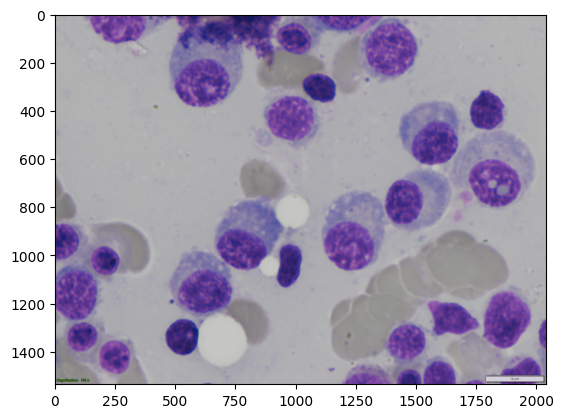

In [3]:
image_path = r"..\..\data\SOTA_segmentation\cell_00068.bmp"
label_path = r"..\..\data\SOTA_segmentation\cell_00068_label.tiff"

image_name = os.path.basename(image_path)
image_name = os.path.splitext(image_name)[0]
print(image_name)

img = io.imread(image_path)

if (len(img.shape) == 2):
    img = np.expand_dims(img, axis=2)  # Add channel dimension if it's grayscale
    # repeat channels so there is 3
    img = np.repeat(img, 3, axis=2)

# Print image information
print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")

plt.imshow(img)

## Import Segmenters and execute_appose from napari_ai_lab

**What are Segmenters?** 
Segmenters are classes that wrap deep learning models with useful logic:
- Check if dependencies are available locally ([see here](https://github.com/True-North-Intelligent-Algorithms/napari-ai-lab/blob/main/src/napari_ai_lab/Segmenters/GlobalSegmenters/CellposeSegmenter.py#L15))
- If not available locally, provide execution strings suitable for Appose ([see here](https://github.com/True-North-Intelligent-Algorithms/napari-ai-lab/blob/main/src/napari_ai_lab/Segmenters/GlobalSegmenters/CellposeSegmenter.py#L184))

**What is execute_appose?**
A utility function ([see here](https://github.com/True-North-Intelligent-Algorithms/napari-ai-lab/blob/main/src/napari_ai_lab/Segmenters/execute_appose.py)) that takes a segmenter and wraps all the Appose logic needed to create environments and call execution strings.

**Note:** This is very early experimental work. Myself and other people will be iterating on such code and better designs will be coming in the future!

In [4]:
from napari_ai_lab.Segmenters.GlobalSegmenters.CellposeSegmenter import CellposeSegmenter
from napari_ai_lab.Segmenters.execute_appose import execute_appose


### Check If Cellpose is Available Locally

Let's see if Cellpose is available in our current environment. Spoiler: it probably isn't, which is perfect for demonstrating Appose!

In [6]:
# Simple cellpose configuration
segmenter = CellposeSegmenter(model_type="cyto2", diameter=100)

run_in_local_environment = segmenter.are_dependencies_available()

print(f"🔍 Cellpose local: {'✅ Available' if run_in_local_environment else '❌ Not found'}")
    

🔍 Cellpose local: ❌ Not found


### Run Cellpose 3 in Different Environment

Now let's call Cellpose 3 using execute_appose! We point to the microsam_cellpose3 environment.

In [7]:
cellpose_env_path = r"..\..\pixi\microsam_cellpose3\.pixi\envs\default"

result = execute_appose(img, segmenter, cellpose_env_path)

cellpose3_result = result.ndarray().copy()

Cellpose not available locally - generated execution string for remote processing
This string can be sent to a cellpose-enabled environment for execution
dict_keys(['mask'])
dict_keys(['mask'])


### Run CellposeSAM in Different Environment

Now let's run cellpose in the ```microsam_cellposesam``` environment.  This one has the newer (version 4) cellpose, that uses SAM, so the reult will be different.  

In [14]:
cellpose_env_path = r"..\..\pixi\microsam_cellposesam\.pixi\envs\default"
#cellpose_env_path = r"C:\\Users\\bnort\\miniconda3\\envs\\microsam_cellpose"

result = execute_appose(img, segmenter, cellpose_env_path)

cellposesam_result= result.ndarray().copy()

Cellpose not available locally - generated execution string for remote processing
This string can be sent to a cellpose-enabled environment for execution
dict_keys(['mask'])
dict_keys(['mask'])


### Check Result Types

Quick check to make sure we got numpy arrays back from both runs.

In [15]:
type(cellpose3_result), type(cellposesam_result)

(numpy.ndarray, numpy.ndarray)

### Prepare for Visualization

Load ground truth and import the visualization helper to create overlays.

In [16]:

# Load ground truth for comparison
ground_truth = io.imread(label_path)
# Import visualization helper
from tnia.plotting.plt_helper import mask_overlay

### Create Ground Truth and Cellpose 3 Overlays

Create overlays for ground truth and Cellpose 3 results.

In [17]:
type(img), type(ground_truth)
ground_truth_overlay = mask_overlay(img, ground_truth)
cellpose3_overlay = mask_overlay(img, cellpose3_result)

### Compare All Results

Finally, let's see how both Cellpose versions performed compared to the ground truth in a nice 3-panel comparison!

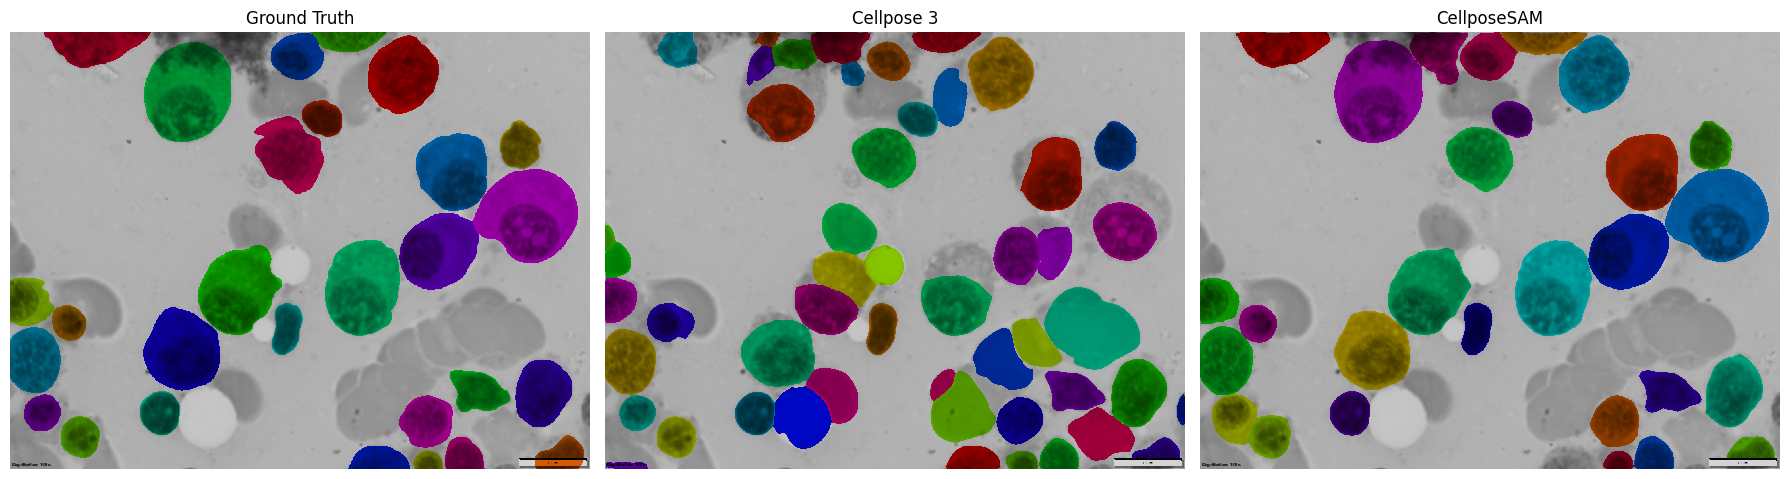

In [18]:


# Create overlays
cellposesam_overlay = mask_overlay(img, cellposesam_result)

# Create 3-panel comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(ground_truth_overlay)
axes[0].set_title('Ground Truth')
axes[0].axis('off')

axes[1].imshow(cellpose3_overlay)
axes[1].set_title('Cellpose 3')
axes[1].axis('off')

axes[2].imshow(cellposesam_overlay)
axes[2].set_title('CellposeSAM')
axes[2].axis('off')

plt.tight_layout()
plt.show()